## 1. Data Exploaration and Visualization

#### Exploring a BigQuery dataset in Datalab

In [3]:
BUCKET = 'qwiklabs-gcp-c7c9baab3ef322d9'
PROJECT = 'qwiklabs-gcp-c7c9baab3ef322d9'
REGION = 'us-central1'

In [4]:
#Setting environment variable in bash
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8'  

Creating the bucket

In [5]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

#### Exploring Data

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that -- this way, twins born on the same day won't end up in different cuts of the data.

In [6]:
# Create SQL query using natality data after the year 2000
query = """
SELECT weight_pounds, is_male, mother_age, plurality, gestation_weeks, ABS(FARM_FINGERPRINT(CONCAT(CAST(year AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM publicdata.samples.natality
WHERE year > 2000 
 """

In [7]:
# Call BigQuery and examine in dataframe
import google.datalab.bigquery as bq
df = bq.Query(query + " LIMIT 100 ").execute().result().to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,3.562670,True,25,1,30,1403073183891835564
1,3.999185,False,30,1,32,7146494315947640619
2,7.438397,True,13,1,34,7146494315947640619
3,4.806077,True,19,1,34,8904940584331855459
4,4.812691,True,22,3,34,2126480030009879160


Let's write a query to find the unique values for each of the columns and the count of those values.
This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [8]:
# Create function that finds the number of records and the average weight for each value of the chosen column
def get_distinct(column_name):
  sql = """
  SELECT {0}, COUNT(1) AS num_babies, AVG(weight_pounds) AS avg_wt
  FROM publicdata.samples.natality
  WHERE year> 2000
  GROUP BY {0} """.format(column_name)
  
  return bq.Query(sql).execute().result().to_dataframe()

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


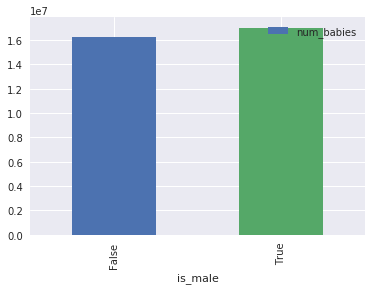

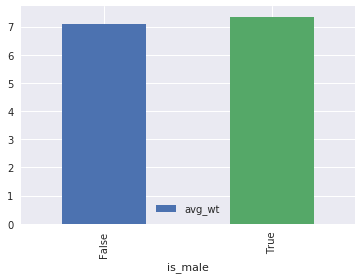

In [9]:
# Bar plot to see is_male with avg_wt linear and num_babies logarithmic
df = get_distinct('is_male')
df.plot('is_male', 'num_babies', kind='bar')
df.plot('is_male', 'avg_wt', kind='bar')

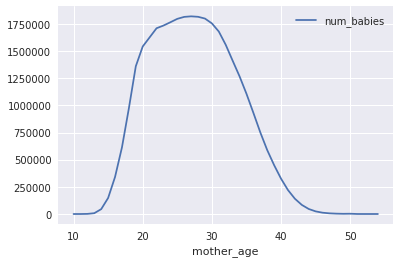

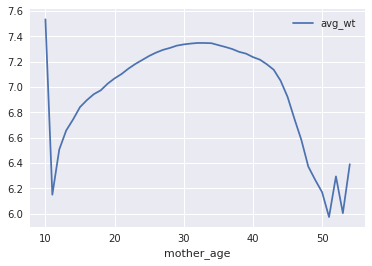

In [10]:
# Line plots to see mother_age with avg_wt linear and num_babies logarithmic
df = get_distinct('mother_age')
df = df.sort_values('mother_age')
df.plot('mother_age', 'num_babies')
df.plot('mother_age', 'avg_wt')

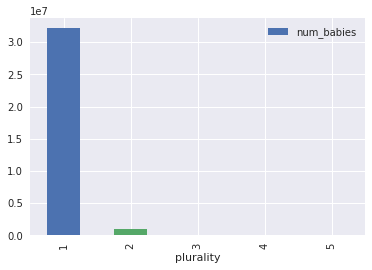

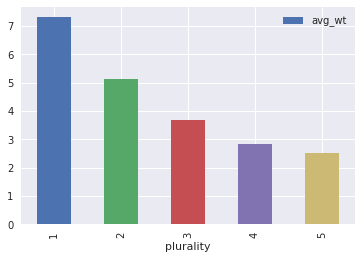

In [11]:
# Bar plot to see plurality(singleton, twins, etc.) with avg_wt linear and num_babies logarithmic
df = get_distinct('plurality')
df = df.sort_values('plurality')
df.plot('plurality', 'num_babies', kind='bar')
df.plot('plurality', 'avg_wt', kind='bar')

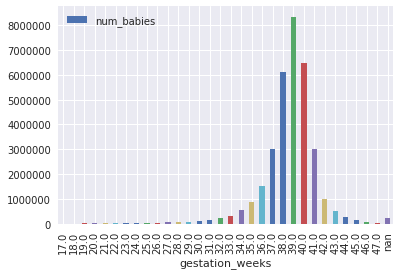

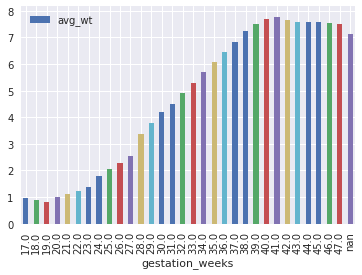

In [12]:
# Bar plot to see gestation_weeks with avg_wt linear and num_babies logarithmic
df = get_distinct('gestation_weeks')
df = df.sort_values('gestation_weeks')
df.plot('gestation_weeks', 'num_babies', kind='bar')
df.plot('gestation_weeks', 'avg_wt', kind='bar')

## 2. Creating a Sampled Dataset


Sampling a BigQuery dataset to create  sampled datasets for ML

In [13]:
# Call BigQuery but GROUP BY the hashmonth and see number of records for each group to enable us to get the correct train and evaluation percentages
df = bq.Query(" SELECT hashmonth, COUNT(1) AS num_babies FROM (" + query + ") GROUP BY hashmonth").execute().result().to_dataframe()
print(len(df))
df.head()

96


,hashmonth,num_babies
0,8391424625589759186,364800
1,7773938200482214258,344069
2,328012383083104805,360198
3,1922480672677032316,367624
4,5742197815970064689,359945


There are only a limited number of years and months in the dataset.So are the hashmonth.

In [14]:
#Here's a way to get a well distributed portion of the data in such a way that the test and train sets do not overlap:
# Added the RAND() so that we can now subsample from each of the hashmonths to get approximately the record counts we want

trainQuery = "SELECT * FROM (" + query + ") WHERE MOD(hashmonth, 4) < 3 AND RAND() < 0.0005"
evalQuery = "SELECT * FROM (" + query + ") WHERE MOD(hashmonth, 4) = 3 AND RAND() < 0.0005"
traindf = bq.Query(trainQuery).execute().result().to_dataframe()
evaldf = bq.Query(evalQuery).execute().result().to_dataframe()
print("There are {0} examles in train dataset and {1} examples in test dataset".format(len(traindf), len(evaldf)))

There are 13101 examles in train dataset and 3274 examples in test dataset


In [15]:
traindf.describe()

,weight_pounds,mother_age,plurality,gestation_weeks,hashmonth
count,13095.000000,13101.000000,13101.000000,13010.000000,1.310100e+04
mean,7.227216,27.375315,1.036562,38.589700,4.378696e+18
std,1.336709,6.166194,0.196435,2.622915,2.809847e+18
min,0.500449,13.000000,1.000000,18.000000,1.244589e+17
25%,6.563162,22.000000,1.000000,38.000000,1.525201e+18
50%,7.312733,27.000000,1.000000,39.000000,4.329667e+18
75%,8.062305,32.000000,1.000000,40.000000,7.108882e+18
max,12.312817,50.000000,4.000000,47.000000,9.183606e+18


Let's add extra rows to simulate the lack of ultrasound. In the process, we'll also change the plurality column to be a string.

Also notice that there are some very important numeric fields that are missing in some rows.
It is always crucial to clean raw data before using in ML.


In [16]:
import pandas as pd

def preprocess(df):
  df = df[df.weight_pounds > 0]
  df = df[df.mother_age > 0]
  df = df[df.plurality > 0]
  df = df[df.gestation_weeks > 0]
  
  plurality_mapping = { 1:'Single(1)', 2:'Twins(2)', 3:'Triplets(3)', 4:'Quadruplets(4)', 5:'Quintuplets(5)'}
  df['plurality'] = df['plurality'].map(plurality_mapping)
  
  no_ultrasound = df.copy(deep=True)
  no_ultrasound['is_male'] = 'Unknown'
  no_ultrasound.loc[no_ultrasound['plurality'] != 'Single(1)', 'plurality'] = 'Mulitple(+2)'
  
  return pd.concat([df, no_ultrasound])

In [17]:
traindf.head()
traindf = preprocess(traindf)
evaldf = preprocess(evaldf)
traindf.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.251004,False,13,Single(1),37.0,411066950820961322
1,4.947173,True,13,Single(1),40.0,1622638268154624360
2,8.124034,True,13,Single(1),41.0,1305143018446161857
3,7.561856,True,13,Single(1),36.0,1451354159195218418
4,6.876218,True,14,Single(1),38.0,5937540421097454372


In [18]:
traindf.describe()

,weight_pounds,mother_age,gestation_weeks,hashmonth
count,26012.000000,26012.000000,26012.000000,2.601200e+04
mean,7.227904,27.371982,38.591573,4.370819e+18
std,1.336497,6.161228,2.617409,2.809291e+18
min,0.500449,13.000000,18.000000,1.244589e+17
25%,6.563162,22.000000,38.000000,1.525201e+18
50%,7.312733,27.000000,39.000000,4.329667e+18
75%,8.062305,32.000000,40.000000,7.108882e+18
max,12.312817,50.000000,47.000000,9.183606e+18


#### Write out
we want to read from files, not Pandas dataframes. So, write the Pandas dataframes out as CSV files. 

In [19]:
traindf.to_csv('train.csv', index=False, header=False)
evaldf.to_csv('eval.csv', index=False, header=False)

## 3. Creating Tensorflow model

In [20]:
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
/usr/local/envs/py2env/lib/python2.7/site-packages/scipy/ndimage/measurements.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _ni_label


1.8.0


In [21]:
df = pd.read_csv('train.csv')
df.head()

,7.25100379718,False,13,Single(1),37.0,411066950820961322
0,4.947173,True,13,Single(1),40.0,1622638268154624360
1,8.124034,True,13,Single(1),41.0,1305143018446161857
2,7.561856,True,13,Single(1),36.0,1451354159195218418
3,6.876218,True,14,Single(1),38.0,5937540421097454372
4,6.933538,True,14,Single(1),39.0,1525201076796226340


In [22]:
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]
TRAIN_STEPS = 1000

In [23]:
# Create an input function reading a file using the Dataset API
def read_dataset(filename, mode, batch_size=512):
  def input_fun():
    def decode_csv(value_column):
      columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
      features = dict(zip(CSV_COLUMNS, columns))
      label = features.pop('weight_pounds')
      return features, label
    
    # Create list of files that match pattern
    file_list = tf.gfile.Glob(filename)
    
    # Create dataset from file list
    dataset = tf.data.TextLineDataset(file_list).map(decode_csv)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
      epochs = None
      dataset = dataset.shuffle(buffer_size=10*batch_size)
    else:
      epochs = 1
    dataset = dataset.repeat(epochs).batch(batch_size)
    
    return dataset.make_one_shot_iterator().get_next()
  return input_fun

In [24]:
#def get_categorical(name, value):
 # return tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(name, value))

In [25]:
#def get_col():
 # return [ get_categorical('is_male', ['True', 'False', 'Unknown']), 
  #         tf.feature_column.numeric_column('mother_age'),
   #        get_categorical('plurality', ['Single(1)', 'Twins(2)', 'Triplets(3)',
    #                   'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)']),
     #      tf.feature_column.numeric_column('gestation_weeks') ]

#### Define feature columns

In [26]:
def get_wide_deep():
  # Define column types
  is_male,mother_age,plurality,gestation_weeks = \
        [\
            tf.feature_column.categorical_column_with_vocabulary_list('is_male', 
                        ['True', 'False', 'Unknown']),
            tf.feature_column.numeric_column('mother_age'),
            tf.feature_column.categorical_column_with_vocabulary_list('plurality',
                        ['Single(1)', 'Twins(2)', 'Triplets(3)',
                         'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)']),
            tf.feature_column.numeric_column('gestation_weeks')
        ]

  age_buckets = tf.feature_column.bucketized_column(mother_age, boundaries=np.arange(15,45,1).tolist())
  gestation_buckets = tf.feature_column.bucketized_column(gestation_weeks, boundaries=np.arange(17, 47, 1).tolist())

  # Sparse columns are wide, have a linear relationship with the output
  wide = [ is_male, plurality, age_buckets, gestation_buckets]

  crossed = tf.feature_column.crossed_column(wide, hash_bucket_size=20000)
  embed = tf.feature_column.embedding_column(crossed, 3)
  
  # Continuous columns are deep, have a complex relationship with the output
  deep = [ mother_age, gestation_weeks, embed]

  return wide, deep

To predict with the TensorFlow model, we also need a serving input function. We will want all the inputs from our user.

In [27]:
def serving_input_fun():
  feature_placeholder = { 'is_male' : tf.placeholder(tf.string, [None]),
                          'mother_age' : tf.placeholder(tf.float32, [None]),
                          'plurality' : tf.placeholder(tf.string, [None]),
                          'gestation_weeks' : tf.placeholder(tf.float32, [None]) }
  features = { key : tf.expand_dims(tensor, -1) for key, tensor in feature_placeholder.items() }
  
  return tf.estimator.export.ServingInputReceiver(features, feature_placeholder) 

In [28]:
# Create estimator to train and evaluate
def train_and_evaluate(output_dir):
  wide, deep = get_wide_deep()
  EVAL_INTERVAL = 300
  run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                      keep_checkpoint_max = 3)
  estimator = tf.estimator.DNNLinearCombinedRegressor(
                       model_dir = output_dir,
                       linear_feature_columns = wide,
                       dnn_feature_columns = deep,
                       dnn_hidden_units = [64, 32],
                       config = run_config)
  train_spec = tf.estimator.TrainSpec(
                       input_fn = read_dataset('train.csv', mode = tf.estimator.ModeKeys.TRAIN),
                       max_steps = TRAIN_STEPS)
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fun)
  eval_spec = tf.estimator.EvalSpec(
                       input_fn = read_dataset('eval.csv', mode = tf.estimator.ModeKeys.EVAL),
                       steps = None,
                       start_delay_secs = 60, # start evaluating after N seconds
                       throttle_secs = EVAL_INTERVAL,  # evaluate every N seconds
                       exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [29]:
# Train the model
shutil.rmtree('babyweight_trained', ignore_errors=True)
train_and_evaluate('babyweight_trained')

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 300, '_session_config': None, '_keep_checkpoint_max': 3, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc7080fb4d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'babyweight_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 300 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tens

In [30]:
from google.datalab.ml import TensorBoard
TensorBoard().start('./babyweight_trained')

/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:30: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .pairwise_fast import _chi2_kernel_fast, _sparse_manhattan


TensorBoard was started successfully with pid 6912. Click here to access it.

6912

## 4. Preprocessing using Dataflow
While Pandas is fine for experimenting, for operationalization of workflow, it is better to do preprocessing in Apache Beam. This will also help to preprocess data in flight, since Apache Beam also allows for streaming.

In [31]:
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [32]:
import google.datalab.bigquery as bq
df = bq.Query(query + " LIMIT 100").execute().result().to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.251004,False,24,1,38.0,1088037545023002395
1,8.750147,False,34,1,40.0,1525201076796226340
2,9.063204,False,27,1,38.0,411066950820961322
3,7.125340,False,33,1,39.0,7146494315947640619
4,6.759373,False,32,1,38.0,7146494315947640619


Activate  Python 2 environment and install Apache Beam.

In [33]:
%%bash
source activate py2env
pip uninstall -y google-cloud-dataflow
conda install -y pytz==2018.4
pip install apache-beam[gcp]

Solving environment: ...working... done

# All requested packages already installed.



Skipping google-cloud-dataflow as it is not installed.


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base -c defaults conda




Cloud Dataflow will read data from BigQuery ,will do some preprocessing, and write it out as CSV files.

In [34]:
import apache_beam as beam
import datetime, os

def to_csv(rowdict):
  # Pull columns from BQ and create a line
  import hashlib
  import copy
  CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks'.split(',')

  # Create synthetic data where we assume that no ultrasound has been performed
  # and so we don't know sex of the baby. Let's assume that we can tell the difference
  # between single and multiple, but that the errors rates in determining exact number
  # is difficult in the absence of an ultrasound.
  no_ultrasound = copy.deepcopy(rowdict)
  w_ultrasound = copy.deepcopy(rowdict)

  no_ultrasound['is_male'] = 'Unknown'
  if rowdict['plurality'] > 1:
    no_ultrasound['plurality'] = 'Multiple(2+)'
  else:
    no_ultrasound['plurality'] = 'Single(1)'

  # Change the plurality column to strings
  w_ultrasound['plurality'] = ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)'][rowdict['plurality'] - 1]

  # Write out two rows for each input row, one with ultrasound and one without
  for result in [no_ultrasound, w_ultrasound]:
    data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
    key = hashlib.sha224(data).hexdigest()  # hash the columns to form a key
    yield str('{},{}'.format(data, key))
  
def preprocess(in_test_mode):
  import shutil, os, subprocess
  job_name = 'preprocess-babyweight-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')

  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './preproc'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/babyweight/preproc/'.format(BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass

  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True
  }
  opts = beam.pipeline.PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'
  else:
      RUNNER = 'DataflowRunner'
  p = beam.Pipeline(RUNNER, options = opts)
  query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
    """

  if in_test_mode:
    query = query + ' LIMIT 100' 

  for step in ['train', 'eval']:
    if step == 'train':
      selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashmonth),4) < 3'.format(query)
    else:
      selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashmonth),4) = 3'.format(query)

    (p 
     | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query = selquery, use_standard_sql = True))
     | '{}_csv'.format(step) >> beam.FlatMap(to_csv)
     | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
    )

  job = p.run()
  if in_test_mode:
    job.wait_until_finish()
    print("Done!")
    
preprocess(in_test_mode = False)

Launching Dataflow job preprocess-babyweight-features-181117-221848 ... hang on


/usr/local/envs/py2env/lib/python2.7/site-packages/apache_beam/runners/dataflow/dataflow_runner.py:795: DeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  standard_options = transform_node.inputs[0].pipeline.options.view_as(
/usr/local/envs/py2env/lib/python2.7/site-packages/oauth2client/contrib/gce.py:99: UserWarning: You have requested explicit scopes to be used with a GCE service account.
Using this argument will have no effect on the actual scopes for tokens
requested. These scopes are set at VM instance creation time and
can't be overridden in the request.

  warnings.warn(_SCOPES_WARNING)


This step will take 20+ minutes. Go to the GCP web console, navigate to the Dataflow section and wait for the job to finish before you run the follwing step

## 5. Training on Cloud ML Engine </h1>

Now, distributed training and hyperparameter tuning on Cloud ML Engine.

In [1]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-aeff7582a8ae3b17'
PROJECT = 'qwiklabs-gcp-aeff7582a8ae3b17'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8'  

In [3]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [4]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/babyweight/preproc; then
  gsutil mb -l ${REGION} gs://${BUCKET}
  # copy  set of preprocessed files from bucket
  gsutil -m cp -R gs://cloud-training-demos/babyweight gs://${BUCKET}
fi

Creating gs://qwiklabs-gcp-aeff7582a8ae3b17/...
ServiceException: 409 Bucket qwiklabs-gcp-aeff7582a8ae3b17 already exists.
Copying gs://cloud-training-demos/babyweight/hyperparam/1/checkpoint...
Copying gs://cloud-training-demos/babyweight/hyperparam/1/eval/events.out.tfevents.1529347627.cmle-training-master-ab97329ccf-0-xfhjt...
Copying gs://cloud-training-demos/babyweight/hyperparam/1/events.out.tfevents.1529347394.cmle-training-master-ab97329ccf-0-xfhjt...
Copying gs://cloud-training-demos/babyweight/hyperparam/1/export/exporter/1529347629/saved_model.pb...
Copying gs://cloud-training-demos/babyweight/hyperparam/1/export/exporter/1529347629/variables/variables.data-00000-of-00001...
Copying gs://cloud-training-demos/babyweight/hyperparam/1/export/exporter/1529347629/variables/variables.index...
Copying gs://cloud-training-demos/babyweight/hyperparam/1/export/exporter/1529347926/saved_model.pb...
Copying gs://cloud-training-demos/babyweight/hyperparam/1/export/exporter/1529347926/var

In [5]:
%bash
gsutil ls gs://${BUCKET}/babyweight/preproc/*-00000*

gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/preproc/eval.csv-00000-of-00012
gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/preproc/train.csv-00000-of-00043


Now that we have the TensorFlow code working on a subset of the data, we can package the TensorFlow code up as a Python module and train it on Cloud ML Engine.
<p>

<p>
Training on Cloud ML Engine requires:
<ol>
<li> Making the code a Python package
<li> Using gcloud to submit the training code to Cloud ML Engine
</ol>

#### Step-1: task.py

The following code edits babyweight/trainer/task.py.

In [7]:
%writefile babyweight/trainer/task.py
import argparse
import json
import os

from . import model

import tensorflow as tf

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--bucket',
        help = 'GCS path to data. We assume that data is in gs://BUCKET/babyweight/preproc/',
        required = True
    )
    parser.add_argument(
        '--output_dir',
        help = 'GCS location to write checkpoints and export models',
        required = True
    )
    parser.add_argument(
        '--batch_size',
        help = 'Number of examples to compute gradient over.',
        type = int,
        default = 512
    )
    parser.add_argument(
        '--job-dir',
        help = 'this model ignores this field, but it is required by gcloud',
        default = 'junk'
    )
    parser.add_argument(
        '--nnsize',
        help = 'Hidden layer sizes to use for DNN feature columns -- provide space-separated layers',
        nargs = '+',
        type = int,
        default=[128, 32, 4]
    )
    parser.add_argument(
        '--nembeds',
        help = 'Embedding size of a cross of n key real-valued parameters',
        type = int,
        default = 3
    )

    ## TODO 1: add the new arguments here 
    parser.add_argument(
        '--train_examples',
        help = 'Number of examples (in thousands) to run the training job over. If this is more than actual # of examples available, it cycles through them. So specifying 1000 here when you have only 100k examples makes this 10 epochs.',
        type = int,
        default = 5000
    )    
    parser.add_argument(
        '--pattern',
        help = 'Specify a pattern that has to be in input files. For example 00001-of will process only one shard',
        default = 'of'
    )
    parser.add_argument(
        '--eval_steps',
        help = 'Positive number of steps for which to evaluate model. Default to None, which means to evaluate until input_fn raises an end-of-input exception',
        type = int,       
        default = None
    )
        
    ## parse all arguments
    args = parser.parse_args()
    arguments = args.__dict__

    # unused args provided by service
    arguments.pop('job_dir', None)
    arguments.pop('job-dir', None)

    ## assign the arguments to the model variables
    output_dir = arguments.pop('output_dir')
    model.BUCKET     = arguments.pop('bucket')
    model.BATCH_SIZE = arguments.pop('batch_size')
    model.TRAIN_STEPS = (arguments.pop('train_examples') * 1000) / model.BATCH_SIZE
    model.EVAL_STEPS = arguments.pop('eval_steps')    
    print ("Will train for {} steps using batch_size={}".format(model.TRAIN_STEPS, model.BATCH_SIZE))
    model.PATTERN = arguments.pop('pattern')
    model.NEMBEDS= arguments.pop('nembeds')
    model.NNSIZE = arguments.pop('nnsize')
    print ("Will use DNN size of {}".format(model.NNSIZE))

    # Append trial_id to path if we are doing hptuning
    # This code can be removed if you are not using hyperparameter tuning
    output_dir = os.path.join(
        output_dir,
        json.loads(
            os.environ.get('TF_CONFIG', '{}')
        ).get('task', {}).get('trial', '')
    )

    # Run the training job
    model.train_and_evaluate(output_dir)

Overwriting babyweight/trainer/task.py


#### Step-2: model.py

The following code edits babyweight/trainer/model.py.

In [8]:
%writefile babyweight/trainer/model.py
import shutil
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

BUCKET = None  # set from task.py
PATTERN = 'of' # gets all files

# Determine CSV, label, and key columns
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]

# Define some hyperparameters
TRAIN_STEPS = 10000
EVAL_STEPS = None
BATCH_SIZE = 512
NEMBEDS = 3
NNSIZE = [64, 16, 4]

# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(prefix, mode, batch_size):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = features.pop(LABEL_COLUMN)
            return features, label
        
        # Use prefix to create file path
        file_path = 'gs://{}/babyweight/preproc/{}*{}*'.format(BUCKET, prefix, PATTERN)

        # Create list of files that match pattern
        file_list = tf.gfile.Glob(file_path)

        # Create dataset from file list
        dataset = (tf.data.TextLineDataset(file_list)  # Read text file
                    .map(decode_csv))  # Transform each elem by applying decode_csv fn
      
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)
        else:
            num_epochs = 1 # end-of-input after this
 
        dataset = dataset.repeat(num_epochs).batch(batch_size)
        return dataset.make_one_shot_iterator().get_next()
    return _input_fn

# Define feature columns
def get_wide_deep():
    # Define column types
    is_male,mother_age,plurality,gestation_weeks = \
        [\
            tf.feature_column.categorical_column_with_vocabulary_list('is_male', 
                        ['True', 'False', 'Unknown']),
            tf.feature_column.numeric_column('mother_age'),
            tf.feature_column.categorical_column_with_vocabulary_list('plurality',
                        ['Single(1)', 'Twins(2)', 'Triplets(3)',
                         'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)']),
            tf.feature_column.numeric_column('gestation_weeks')
        ]

    # Discretize
    age_buckets = tf.feature_column.bucketized_column(mother_age, 
                        boundaries=np.arange(15,45,1).tolist())
    gestation_buckets = tf.feature_column.bucketized_column(gestation_weeks, 
                        boundaries=np.arange(17,47,1).tolist())
      
    # Sparse columns are wide, have a linear relationship with the output
    wide = [is_male,
            plurality,
            age_buckets,
            gestation_buckets]
    
    # Feature cross all the wide columns and embed into a lower dimension
    crossed = tf.feature_column.crossed_column(wide, hash_bucket_size=20000)
    embed = tf.feature_column.embedding_column(crossed, NEMBEDS)
    
    # Continuous columns are deep, have a complex relationship with the output
    deep = [mother_age,
            gestation_weeks,
            embed]
    return wide, deep

# Create serving input function to be able to serve predictions later using provided inputs
def serving_input_fn():
    feature_placeholders = {
        'is_male': tf.placeholder(tf.string, [None]),
        'mother_age': tf.placeholder(tf.float32, [None]),
        'plurality': tf.placeholder(tf.string, [None]),
        'gestation_weeks': tf.placeholder(tf.float32, [None]),
        KEY_COLUMN: tf.placeholder_with_default(tf.constant(['nokey']), [None])
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

# create metric for hyperparameter tuning
def my_rmse(labels, predictions):
    pred_values = predictions['predictions']
    return {'rmse': tf.metrics.root_mean_squared_error(labels, pred_values)}

# Create estimator to train and evaluate
def train_and_evaluate(output_dir):
    wide, deep = get_wide_deep()
    EVAL_INTERVAL = 300 # seconds

    ## TODO 2a: set the save_checkpoints_secs to the EVAL_INTERVAL
    run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                        keep_checkpoint_max = 3)
    
    ## TODO 2b: change the dnn_hidden_units to NNSIZE
    estimator = tf.estimator.DNNLinearCombinedRegressor(
        model_dir = output_dir,
        linear_feature_columns = wide,
        dnn_feature_columns = deep,
        dnn_hidden_units = NNSIZE,
        config = run_config)
    
    # illustrates how to add an extra metric
    estimator = tf.contrib.estimator.add_metrics(estimator, my_rmse)
    # for batch prediction, you need a key associated with each instance
    estimator = tf.contrib.estimator.forward_features(estimator, KEY_COLUMN)
    
    ## TODO 2c: Set the third argument of read_dataset to BATCH_SIZE 
    ## TODO 2d: and set max_steps to TRAIN_STEPS
    train_spec = tf.estimator.TrainSpec(
        input_fn = read_dataset('train', tf.estimator.ModeKeys.TRAIN, BATCH_SIZE),
        max_steps = TRAIN_STEPS)
    
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn, exports_to_keep=None)

    ## TODO 2e: Lastly, set steps equal to EVAL_STEPS
    eval_spec = tf.estimator.EvalSpec(
        input_fn = read_dataset('eval', tf.estimator.ModeKeys.EVAL, 2**15),  # no need to batch in eval
        steps = EVAL_STEPS,
        start_delay_secs = 60, # start evaluating after N seconds
        throttle_secs = EVAL_INTERVAL,  # evaluate every N seconds
        exporters = exporter)
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Overwriting babyweight/trainer/model.py



#### Step-3
After moving the code to a package, make sure it works standalone.

In [9]:
%bash
echo "bucket=${BUCKET}"
rm -rf babyweight_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/babyweight
python -m trainer.task \
  --bucket=${BUCKET} \
  --output_dir=babyweight_trained \
  --job-dir=./tmp \
  --pattern="00000-of-" --train_examples=1 --eval_steps=1

bucket=qwiklabs-gcp-aeff7582a8ae3b17
Will train for 1.953125 steps using batch_size=512
Will use DNN size of [128, 32, 4]


/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe9c4df6c50>, '_num_worker_replicas': 1, '_train_distribute': None, '_service': None, '_master': '', '_tf_random_seed': None, '_task_type': 'worker', '_evaluation_master': '', '_num_ps_replicas': 0, '_global_id_in_cluster': 0, '_task_id': 0, '_model_dir': 'babyweight_trained/', '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_is_chief': True, '_session_config': None, '_save_checkpoints_secs': 300, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 3}
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow

#### Step-4
The JSON below represents an input into your prediction model. 

In [10]:
%writefile inputs.json
{"key": "b1", "is_male": "True", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}
{"key": "g1", "is_male": "False", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}

Writing inputs.json


In [11]:
## This doesn't play nice with Python 3, so skipping for now.
##%bash
##MODEL_LOCATION=$(ls -d $(pwd)/babyweight_trained/export/exporter/* | tail -1)
##echo $MODEL_LOCATION
##gcloud ml-engine local predict --model-dir=$MODEL_LOCATION --json-instances=inputs.json

#### Step-5

Once the code works in standalone mode, we can run it on Cloud ML Engine.  Because this is on the entire dataset, it will take a while. The training run took about <b> an hour </b> for me. You can monitor the job from the GCP console in the Cloud Machine Learning Engine section.

In [12]:
%bash
OUTDIR=gs://${BUCKET}/babyweight/trained_model
JOBNAME=babyweight_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/babyweight/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=$TFVERSION \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --train_examples=200000

gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model us-central1 babyweight_181118_084055
jobId: babyweight_181118_084055
state: QUEUED


Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/checkpoint#1542530340909554...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/eval/events.out.tfevents.1529348264.cmle-training-master-a137ac0fff-0-9q8r4#1542530335839228...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/events.out.tfevents.1529347276.cmle-training-master-a137ac0fff-0-9q8r4#1542530338379663...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/export/exporter/1529348266/saved_model.pb#1542530340028709...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/export/exporter/1529348266/variables/variables.data-00000-of-00001#1542530343630550...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/export/exporter/1529348266/variables/variables.index#1542530343966683...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/export/exporter/1529348864/saved_model.pb#1542530345900820...
Removing gs://q

When I ran it, I used train_examples=2000000. When training finished, I filtered in the Stackdriver log on the word "dict" and saw that the last line was:
<pre>
Saving dict for global step 5714290: average_loss = 1.06473, global_step = 5714290, loss = 34882.4, rmse = 1.03186
</pre>
The final RMSE was 1.03 pounds.

In [13]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/babyweight/trained_model'.format(BUCKET))

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorBoard was started successfully with pid 6487. Click here to access it.

6487

In [14]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

Stopped TensorBoard with pid 6487


## 6. Hyperparameter tuning </h2>
<p>
All of these are command-line parameters to my program.  To do hyperparameter tuning, create hyperparam.xml and pass it as --configFile.
This step will take <b>1 hour</b> -- you can increase maxParallelTrials or reduce maxTrials to get it done faster.  Since maxParallelTrials is the number of initial seeds to start searching from, you don't want it to be too large; otherwise, all you have is a random search.


In [15]:
%writefile hyperparam.yaml
trainingInput:
  scaleTier: STANDARD_1
  hyperparameters:
    hyperparameterMetricTag: rmse
    goal: MINIMIZE
    maxTrials: 20
    maxParallelTrials: 5
    enableTrialEarlyStopping: True
    params:
    - parameterName: batch_size
      type: INTEGER
      minValue: 8
      maxValue: 512
      scaleType: UNIT_LOG_SCALE
    - parameterName: nembeds
      type: INTEGER
      minValue: 3
      maxValue: 30
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: nnsize
      type: INTEGER
      minValue: 64
      maxValue: 512
      scaleType: UNIT_LOG_SCALE

Writing hyperparam.yaml


In [16]:
%bash
OUTDIR=gs://${BUCKET}/babyweight/hyperparam
JOBNAME=babyweight_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/babyweight/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --config=hyperparam.yaml \
  --runtime-version=$TFVERSION \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --eval_steps=10 \
  --train_examples=20000

gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/hyperparam us-central1 babyweight_181118_084109
jobId: babyweight_181118_084109
state: QUEUED


Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/hyperparam/1/checkpoint#1542529757571322...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/hyperparam/1/eval/events.out.tfevents.1529347627.cmle-training-master-ab97329ccf-0-xfhjt#1542529762622328...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/hyperparam/1/events.out.tfevents.1529347394.cmle-training-master-ab97329ccf-0-xfhjt#1542529759934858...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/hyperparam/1/export/exporter/1529347629/saved_model.pb#1542529759313731...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/hyperparam/1/export/exporter/1529347629/variables/variables.data-00000-of-00001#1542529757682753...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/hyperparam/1/export/exporter/1529347629/variables/variables.index#1542529761504516...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/hyperparam/1/export/exporter/1529347926/saved_model.pb#1542529759917898...
Removing gs://qwiklabs

### Repeat training
<p>
This time with tuned parameters (note last line)

In [17]:
%bash
OUTDIR=gs://${BUCKET}/babyweight/trained_model_tuned
JOBNAME=babyweight_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/babyweight/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=$TFVERSION \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --train_examples=20000 --batch_size=35 --nembeds=16 --nnsize=281

gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model_tuned us-central1 babyweight_181118_084134
jobId: babyweight_181118_084134
state: QUEUED


Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model_tuned/checkpoint#1542530397689500...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model_tuned/eval/events.out.tfevents.1529348486.cmle-training-master-d20efff6e7-0-gtx4t#1542530397964830...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model_tuned/events.out.tfevents.1529347278.cmle-training-master-d20efff6e7-0-gtx4t#1542530399658288...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model_tuned/export/exporter/1529348487/saved_model.pb#1542530406376830...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model_tuned/export/exporter/1529348487/variables/variables.data-00000-of-00001#1542530401911519...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model_tuned/export/exporter/1529348487/variables/variables.index#1542530400247445...
Removing gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model_tuned/export/exporter/1529349318/saved_mo

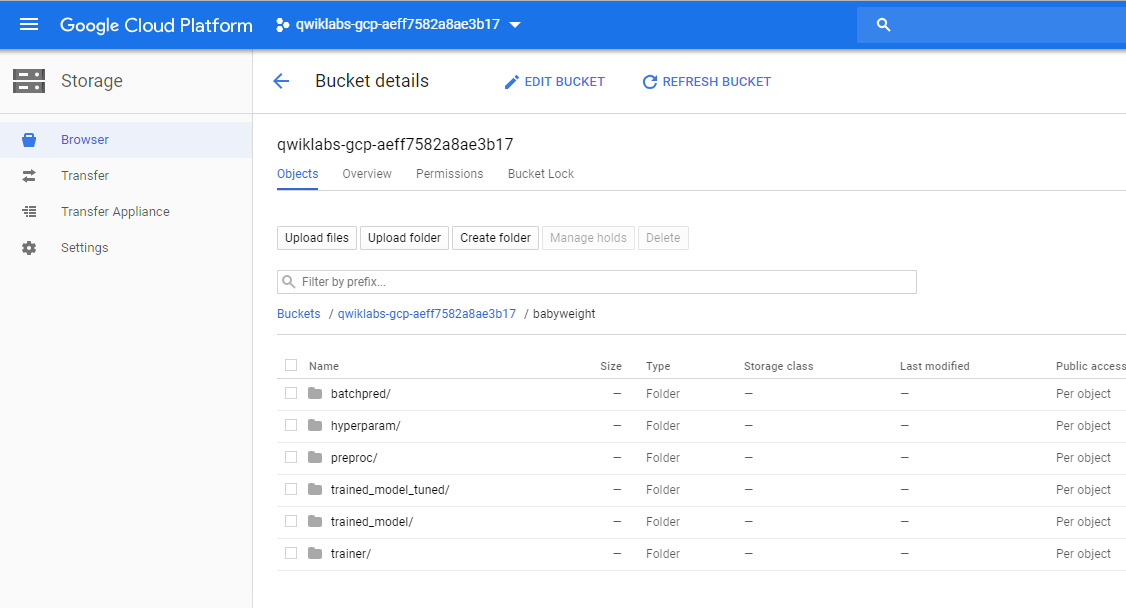

In [3]:
from IPython.display import Image
Image(filename='333.PNG')


## 7. Deploying and predicting with model </h1>


<ol>
<li> Deploying model
<li> Predicting with model
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-aeff7582a8ae3b17'
PROJECT = 'qwiklabs-gcp-aeff7582a8ae3b17'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.7'  

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/babyweight/trained_model; then
  gsutil mb -l ${REGION} gs://${BUCKET}
  # copy canonical model if you didn't do previous notebook
  gsutil -m cp -R gs://cloud-training-demos/babyweight/trained_model gs://${BUCKET}/babyweight/trained_model
fi

Creating gs://qwiklabs-gcp-aeff7582a8ae3b17/...
ServiceException: 409 Bucket qwiklabs-gcp-aeff7582a8ae3b17 already exists.
Copying gs://cloud-training-demos/babyweight/trained_model/checkpoint...
Copying gs://cloud-training-demos/babyweight/trained_model/eval/events.out.tfevents.1529348264.cmle-training-master-a137ac0fff-0-9q8r4...
Copying gs://cloud-training-demos/babyweight/trained_model/events.out.tfevents.1529347276.cmle-training-master-a137ac0fff-0-9q8r4...
Copying gs://cloud-training-demos/babyweight/trained_model/export/exporter/1529348266/saved_model.pb...
Copying gs://cloud-training-demos/babyweight/trained_model/export/exporter/1529348266/variables/variables.data-00000-of-00001...
Copying gs://cloud-training-demos/babyweight/trained_model/export/exporter/1529348266/variables/variables.index...
Copying gs://cloud-training-demos/babyweight/trained_model/export/exporter/1529348864/saved_model.pb...
Copying gs://cloud-training-demos/babyweight/trained_model/export/exporter/152934

#### Deploy trained model 
<p>
Deploying the trained model to act as a REST web service is a simple gcloud call.

In [4]:
%bash
gsutil ls gs://${BUCKET}/babyweight/trained_model/export/exporter/

gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/export/exporter/
gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/export/exporter/1542531774/
gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/export/exporter/1542532433/


In [5]:
%bash
MODEL_NAME="babyweight"
MODEL_VERSION="ml_on_gcp"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/babyweight/trained_model/export/exporter/ | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version $TFVERSION

Deleting and deploying babyweight ml_on_gcp from gs://qwiklabs-gcp-aeff7582a8ae3b17/babyweight/trained_model/export/exporter/1542532433/ ... this will take a few minutes


Created ml engine model [projects/qwiklabs-gcp-aeff7582a8ae3b17/models/babyweight].
Creating version (this might take a few minutes)......
........................................................................................................................................................................................................................................................................................................................................................done.


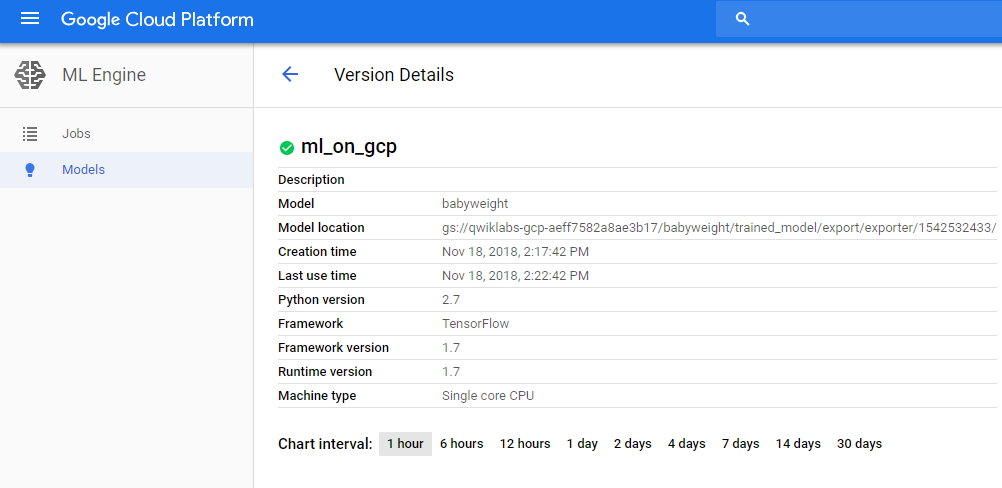

In [2]:
from IPython.display import Image
Image(filename='11.PNG')

#### Use model to predict (online prediction) </h2>
<p>
Send a JSON request to the endpoint of the service to make it predict a baby's weight. The order of the responses are the order of the instances.

In [6]:
from oauth2client.client import GoogleCredentials
import requests
import json

MODEL_NAME = 'babyweight'
MODEL_VERSION = 'ml_on_gcp'

token = GoogleCredentials.get_application_default().get_access_token().access_token
api = 'https://ml.googleapis.com/v1/projects/{}/models/{}/versions/{}:predict' \
         .format(PROJECT, MODEL_NAME, MODEL_VERSION)
headers = {'Authorization': 'Bearer ' + token }
data = {
  'instances': [
    {


      'key': 'b1',
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 39
    },
    {
      'key': 'g1',
      'is_male': 'False',
      'mother_age': 29.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 38
    },
    {
      'key': 'b2',
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Triplets(3)',
      'gestation_weeks': 39
    },
    {
      'key': 'u1',
      'is_male': 'Unknown',
      'mother_age': 29.0,
      'plurality': 'Multiple(2+)',
      'gestation_weeks': 38
    },
  ]
}
response = requests.post(api, json=data, headers=headers)
print(response.content)

b'{"predictions": [{"predictions": [7.3764543533325195], "key": ["b1"]}, {"predictions": [6.7464070320129395], "key": ["g1"]}, {"predictions": [6.395363807678223], "key": ["b2"]}, {"predictions": [5.705104827880859], "key": ["u1"]}]}'


The predictions for the four instances were: 7.66, 7.22, 6.32 and 6.19 pounds respectively when I ran it .

##  8. Flask API to invoke prediction from deployed model

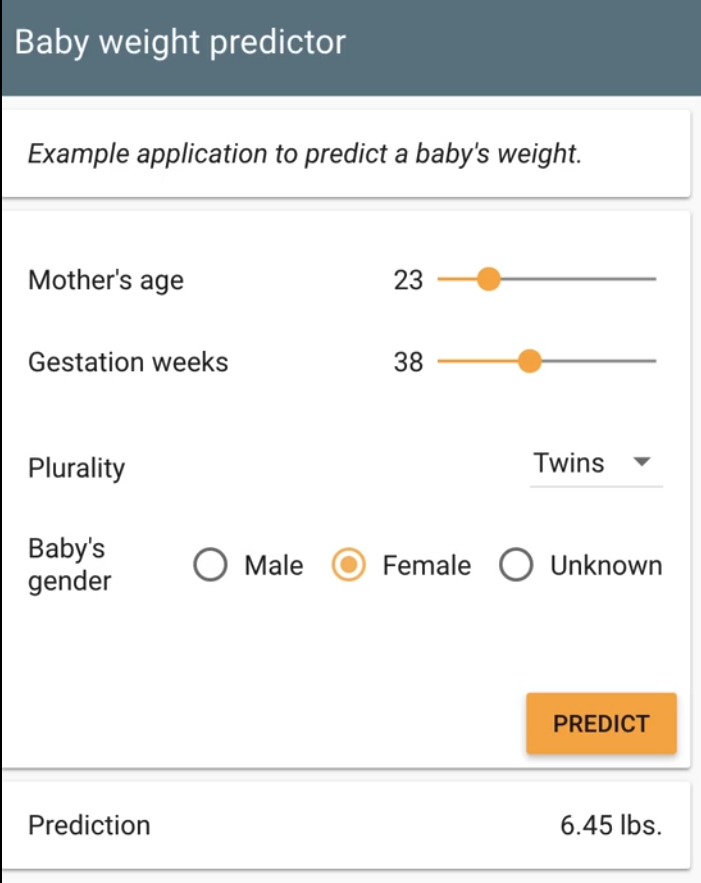

In [1]:
from IPython.display import Image
Image(filename='444.PNG')